<a href="https://colab.research.google.com/github/IFuentesSR/Reservoir_area_Sentinel2/blob/main/ETcmrset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=cGUdWfH0t_a1NSfD8K0e7VDOrLFqaGviAWFF_X9HoV0&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWh3YU4O06zvRm2f43AJ5toKqOXoMEWxFDx5wbqzwS-6xdRuZmgTM88

Successfully saved authorization token.


In [ ]:
# Folium setup.
import folium
import datetime
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn import linear_model
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline

print(folium.__version__)

0.8.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### CMRSET evapotranspiration calculations

### Kc

Set of equations for estimating the crop coefficient Kc using the CMRSET evapotranspiration methodology 

In [ ]:
def getS2_CLOUD_PROBABILITY(geo):
    innerJoined = ee.Join.inner().apply(primary=ee.ImageCollection("COPERNICUS/S2").filterBounds(geo).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 15)),
                                        secondary=ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filterBounds(geo),
                                        condition=ee.Filter.equals(leftField='system:index',
                                                                   rightField='system:index'))
    def mergeImageBands(joinResult):
        return ee.Image(joinResult.get('primary')).addBands(joinResult.get('secondary'))

    newCollection = innerJoined.map(mergeImageBands)
    return ee.ImageCollection(newCollection)


def LandsatcloudShadowMask(img):
    cloudMask = img.select('pixel_qa').bitwiseAnd(32).eq(0)
    masked = img.updateMask(cloudMask)
    shadowMask = img.select('pixel_qa').bitwiseAnd(8).eq(0)#.And(img.select('pixel_qa').bitwiseAnd(16).eq(0))
    return masked.updateMask(shadowMask).multiply(0.0001)


def band_conversion(img):
    bands = ['B1','B2','B3','B4','B5','B6','B7','pixel_qa']
    B6 = (img.select('B10').add(img.select('B11'))).divide(2).rename('B6').toInt16()
    toRetrieve = img.select(['B2','B3','B4','B5','B6','B7','pixel_qa']).rename(['B1','B2','B3','B4','B5','B7','pixel_qa']).addBands(B6)
    return toRetrieve.select(bands)


def get_landsat(geo):
    bands = ['B1','B2','B3','B4','B5','B6','B7','pixel_qa']
    bands1 = ['B2','B3','B4','B5','B6','B7','B10','B11','pixel_qa']
    l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR').select(bands).filterBounds(geo)
    l7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').select(bands).filterBounds(geo)
    l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').select(bands1).filterBounds(geo).map(band_conversion)
    Ls = l5.merge(l7).merge(l8)
    Ls = Ls.map(LandsatcloudShadowMask).sort('system:time_start')
    return Ls


def maskClouds(_img):
    props = _img.propertyNames()
    cloudProbabilityThreshold = 30
    cloudMask = _img.select('probability').lt(cloudProbabilityThreshold)
    return _img.updateMask(cloudMask).multiply(0.0001).copyProperties(_img, props)


def CloudMaskS2(image):
    prop = image.propertyNames()
    QA = image.select('SCL')
    clouds = 9;
    cirrus = 8;
    thin_cirrus = 10;
    shadows = 3;
    mask = QA.neq(clouds).And(QA.neq(shadows)).And(QA.neq(thin_cirrus))  # .and(QA.neq(cirrus));
    return image.updateMask(mask).multiply(0.0001).copyProperties(image, prop);


def NDVI(coll=0):
    # 0 for landsat
    def inner(img):
        condition = ee.Algorithms.If(ee.Number(coll).eq(0),
                                     img.normalizedDifference(['B4', 'B3']),
                                     img.normalizedDifference(['B8', 'B4']))
        ndvi = ee.Image(condition)    
        return img.addBands(ndvi.rename('NDVI')).copyProperties(img, ['system:time_start'])
    return inner


def EVI(coll=0):
    def inner(img):
        condition = ee.Algorithms.If(ee.Number(coll).eq(0),
                                     img.expression('2.5 * (NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1)',
                                                    {'NIR':img.select('B4'), 'Red': img.select('B3'), 'Blue':img.select('B1')}),
                                     img.expression('2.5 * (NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1)',
                                                    {'NIR':img.select('B8'), 'Red': img.select('B4'), 'Blue':img.select('B2')}))
        evi = ee.Image(condition)
        evir = evi.divide(0.9).clamp(0, 1)
        return img.addBands([evi.rename('EVI'), evir.rename('EVIr')]).copyProperties(img, ['system:time_start'])
    return inner


def GVMI(coll=0):
    def inner(img):
        condition = ee.Algorithms.If(ee.Number(coll).eq(0),
                                     img.expression('((NIR + 0.1)-(SWIR2 + 0.02)) / ((NIR + 0.1)+(SWIR2 + 0.02))',
                                                    {'NIR':img.select('B4'), 'SWIR2':img.select('B7')}),
                                     img.expression('((NIR + 0.1)-(SWIR2 + 0.02)) / ((NIR + 0.1)+(SWIR2 + 0.02))',
                                                    {'NIR':img.select('B8'), 'SWIR2':img.select('B12')}))
        gvmi = ee.Image(condition)
        return img.addBands(gvmi.rename('GVMI')).copyProperties(img, ['system:time_start'])
    return inner


def RMI(img):
    gvmi = img.select('GVMI')
    evi = img.select('EVI')
    rmi = gvmi.expression('gvmi - (0.775 * evi - 0.0757)',
                          {'gvmi': gvmi, 'evi':evi}).clamp(0, 1)
    return img.addBands(rmi.rename('RMI')).copyProperties(img, ['system:time_start'])


def kc(img):
    k = img.expression('0.68 * (1 - exp(-14.12 * EVIr**2.482 + -7.991 * RMI**0.89))',
                      {'EVIr': img.select('EVIr'), 'RMI': img.select('RMI')})
    # k = ee.Image(0.68).multiply(ee.Image(1).subtract(ee.Image(-14.12).multiply(img.select('EVIr').pow(ee.Image(2.482))).add(ee.Image(-7.991).multiply(img.select('RMI').pow(0.89))).exp()))
    return img.addBands(k.rename('Kc')).copyProperties(img, ['system:time_start'])


In [ ]:
def month_aggregation(coll, start):
    def inner(month):
        date0 = ee.Date(start)
        date1 = date0.advance(ee.Number(month), 'month')
        date2 = date1.advance(1, 'month')
        S2_m = coll.filterDate(date1, date2).mean()
        return S2_m.setMulti({'system:time_start': date1.millis(),
                              'system:time_end': date2.millis(),
                              'date': date1.format('YYYY_MM_dd')})
    return inner
    

def get_S2(geometry, start, end, monthly=None):
    s2 = getS2_CLOUD_PROBABILITY(geometry).filterDate(ee.Date(start), ee.Date(end)).map(maskClouds)
    if monthly:
        months = ee.List.sequence(0, 13)
        s2 = ee.ImageCollection.fromImages(months.map(month_aggregation(s2, start)))
    coll = s2.map(NDVI(1)).map(EVI(1)).map(GVMI(1)).map(RMI).map(kc)
    return coll
    

### Variables definition

In [ ]:
geo1 = ee.Geometry.Point([149.981, -30.468]) #id 205
# geo1 = ee.Geometry.Point([149.931, -30.410]) #id 13
start_date = "2017-07-01"
end_date = '2018-08-31'
monthly = True # None for daily and True for monthly
# geo1 = ee.Geometry.Point([149.7543738, -29.3741845])

test = get_S2(geo1, start_date, end_date, monthly)

# Ls = get_landsat(geo1).filterDate("2020-09-01", '2021-01-01')

In [ ]:
print(test.size().getInfo())

14


### Reflectance, EVI, and Kc maps for month 0 (July)

In [ ]:
mapidCon = test.first().getMapId({'min': 0, 'max': 0.3, 'bands': ['B8', 'B4', 'B3']})
mapidEVI = ee.Image(test.first()).select('EVI').getMapId({'min': -1, 'max': 1, 'palette': ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']})
mapidKc = ee.Image(test.first()).select('Kc').getMapId({'min': 0, 'max': 0.8, 'palette': ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']})
# mapDam = ee.Feature(ee.Feature(NSWdams.first()).geometry().buffer(200).bounds()).getMapId()
centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=13)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='sat',
  ).add_to(map)
folium.TileLayer(
    tiles=mapidEVI['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='NDVI',
  ).add_to(map)
folium.TileLayer(
    tiles=mapidKc['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Kc',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### FAO56 ETr 

In [ ]:
print(test.size().getInfo())

12


In [ ]:
lat = ee.Image.pixelLonLat().select('latitude').multiply(np.pi / 180)
lon = ee.Image.pixelLonLat().select('longitude').multiply(np.pi / 180)


def select_data(monthly=None):
    def inner(img):
        date = ee.Date(img.get('system:time_start'))
        if monthly:
            gdal = ee.ImageCollection("NASA/FLDAS/NOAH01/C/GL/M/V001").filterDate(date, date.advance(15, 'day')).select(['SWdown_f_tavg'])
            radiation = gdal.first().multiply(0.0864)
            era5 = ee.ImageCollection("ECMWF/ERA5/MONTHLY").filterDate(date, date.advance(15, 'day')).first()
            previous = ee.ImageCollection("ECMWF/ERA5/MONTHLY").filterDate(date.advance(-1, 'month'), date.advance(-15, 'day')).first().select('mean_2m_air_temperature')
            after = ee.ImageCollection("ECMWF/ERA5/MONTHLY").filterDate(date.advance(1, 'month'), date.advance(45, 'day')).first().select('mean_2m_air_temperature')
            image = era5.addBands([radiation.rename('radiation'), previous.rename('previous'), after.rename('after')]).set('system:time:start', date.millis())
        else:
            gdal = ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H").filterDate(date, date.advance(1, 'day')).select(['SWdown_f_tavg'])
            radiation = gdal.mean().multiply(0.0864)
            era5 = ee.ImageCollection("ECMWF/ERA5/DAILY").filterDate(date, date.advance(1, 'day')).first()
            image = era5.addBands(radiation.rename('radiation')).set('system:time:start', date.millis())
        return image
    return inner


def psy(img):
  return img.select('surface_pressure').divide(1000).multiply(0.000665)


def vapor_pressure_func(t):
  return t.expression('0.6108 * exp(17.27 * b() / (b() + 237.3))')


def ETr(monthly=None):
    def inner(img):

        es_tmax = vapor_pressure_func(img.select('maximum_2m_air_temperature').subtract(273))# C
    
        es_tmin = vapor_pressure_func(img.select('minimum_2m_air_temperature').subtract(273))#   C
    
        es_tmean = vapor_pressure_func(img.select('mean_2m_air_temperature').subtract(273))
    
        es_slope = img.select('mean_2m_air_temperature').subtract(273).expression(
            '2503 * exp(17.27 * b() / (b() + 237.3)) / (pow((b() + 237.3), 2))')
    
        es = es_tmin.add(es_tmax).multiply(0.5)
    
        ea = vapor_pressure_func(img.select('dewpoint_2m_temperature').subtract(273))
        wind_speed = img.select('u_component_of_wind_10m').pow(2).add(img.select('v_component_of_wind_10m').pow(2)).sqrt()
        wind_speed = wind_speed.multiply(4.87).divide((ee.Image(10).multiply(67.8).subtract(5.42)).log())
    
        second = ee.Image(psy(img)).multiply(ee.Image(900).divide(img.select('mean_2m_air_temperature'))).multiply(wind_speed).multiply(es.subtract(ea))
        denominator = es_slope.add(ee.Image(psy(img)).multiply(wind_speed.multiply(0.34).add(1)))
    
    
        rs = ee.Image(img).select(['radiation'])
        doy = ee.Number(ee.Date(img.get('system:time_start')).getRelative('day', 'year')).add(1)
        if monthly:
            doy = ee.Image(30.4).multiply(ee.Date(img.get('system:time_start')).get('month')).subtract(15).round()
        delta = doy.multiply(2 * np.pi / 365).subtract(1.39435).sin().multiply(0.40928)
        # delta = doy.multiply(2 * np.pi / 365).subtract(1.39).sin().multiply(0.409)
        omegas = lat.expression('acos(-tan(lat) * tan(delta))', {'lat':lat, 'delta':delta})
        theta = omegas.expression('omegas * sin(lat) * sin(delta) + cos(lat) * cos(delta) * sin(omegas)',
                                {'omegas':omegas, 'lat':lat, 'delta':delta})
        
        G = 0 # G = 0 for daily, for monthly use above equation
        if monthly:
            G = img.select('after').subtract(img.select('previous')).multiply(0.07)  
        
        dr = doy.multiply(2 * np.pi / 365).cos().multiply(0.033).add(1)
        ra = theta.expression('(24 / pi) * gsc * dr * theta', {'pi':np.pi, 'gsc':4.92, 'dr':dr, 'theta':theta});
        sin_beta_24 = lat.expression('sin(0.85 + 0.3 * lat * sin(delta) - 0.42 * pow(lat,2))',
                                    {'lat':lat, 'delta':doy.multiply(2 * np.pi / 365).subtract(1.39)})
        sin_beta_24 = sin_beta_24.where(sin_beta_24.lt(0), 0)
        pa = img.select('surface_pressure')
        # Precipitable water (Eqn D.3)
        w = pa.expression('0.14 * ea * pa + 2.1',
                        {'pa':pa, 'ea':ea})    
        # Clearness index for direct beam radiation (Eqn D.2)
        # Limit sin_beta >= 0.01 so that KB does not go undefined
    
        kb = pa.expression('0.98 * exp((-0.00146 * pa) / (kt * sin_beta) - 0.075 * pow((w / sin_beta), 0.4))',
                        {'pa':pa, 'kt':1.0, 'sin_beta':sin_beta_24, 'w':w})
        # Transmissivity index for diffuse radiation (Eqn D.4)
        # kd = kb.multiply(-0.36).add(0.35)
        # .min(kb.multiply(0.82).add(0.18));
        kd = kb.multiply(-0.36).add(0.35).where(kb.lt(0.15), kb.multiply(0.82).add(0.18))
        # (Eqn D.1)
        rso = ra.multiply(kb.add(kd))

        # Cloudiness fraction (Eqn 18)
        fcd = rs.divide(rso).clamp(0.3,1).multiply(1.35).subtract(0.35)

        # Net long-wave radiation (Eqn 17)
        rnl = ea.expression('4.901 *pow(10,-9) * fcd * (0.34 - 0.14 * sqrt(ea)) * '+
                            '(pow(tmax_k, 4) + pow(tmin_k, 4)) / 2',
                            {'ea':ea, 'fcd':fcd, 'tmax_k':img.select('maximum_2m_air_temperature'),
                            'tmin_k':img.select('minimum_2m_air_temperature')})

        # Net radiation (Eqns 15 and 16)
        rn = rs.multiply(0.77).subtract(rnl)
        first = es_slope.multiply(rn.subtract(G)).multiply(0.408)
        # days = ee.Date(img.get('system:time_start')).advance(1, 'month').difference(img.get('system:time_start'), 'day')
        retrieve = first.add(second).divide(denominator)#.multiply(days)
        return retrieve.where(retrieve.lte(0), 0.01).copyProperties(img, ['system:time_start'])
    return inner



def AET(monthly=None):
    def inner(img):
        img = ee.Image(img)
        props = img.propertyNames()
        meteo = ee.ImageCollection(img).map(select_data(monthly))
        etr = ee.Image(meteo.map(ETr(monthly)).first()).resample('bicubic')
        aet = img.select('Kc').multiply(etr)
        return img.addBands([etr.rename('ETr'), aet.rename('AET')]).copyProperties(img, props)
    return inner


### Runing ETr

In [ ]:
testing = test.map(select_data(monthly)).map(ETr(monthly))

In [ ]:
def to_date(stri):
    return ee.Date(stri).format('YYYY-MM-dd')

band_names = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
              'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul1', 'Aug1']

print(testing.aggregate_array('system:time_start').map(to_date).getInfo())
# ee.batch.Export.image.toDrive(testing.toBands().rename(band_names).resample('bicubic'),
#                               description='lot1_etr_1',
#                               scale=10,
#                               region=geometry.geometry(),
#                               maxPixels=1e13).start()

['2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01']


In [ ]:
mapidCon = ee.Image(testing.toBands().rename(band_names).resample('bicubic').select('Jul')).getMapId({'min': 0, 'max': 14, 'palette': 'FF0000, FFFF00, 00FF00, 00FFFF, 0000FF'})
centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='ETr',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### ETr map for july

In [ ]:
mapidCon = ee.Image(testing.first()).resample('bicubic').getMapId({'min': 0, 'max': 14, 'palette': 'FF0000, FFFF00, 00FF00, 00FFFF, 0000FF'})
centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=2)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='ETr',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

## Monthly average ETr plot for paddock

In [ ]:
lots = ee.FeatureCollection("users/ignisfausto/clusters")
ex = lots.filter(ee.Filter.eq('C_ID', 205)) # 13 or 205
geometry = ee.Feature(ex.first())
area = geometry.area().getInfo()
width = 1
if monthly:
    width=5

In [ ]:
geometry2.area(1).getInfo()/10000

1032.5704869982626

In [ ]:
ex2 = lots.filter(ee.Filter.eq('C_ID', 13)) # 13 or 205
geometry2 = ee.Feature(ex2.first())
area2 = geometry2.area().getInfo()
width = 1
if monthly:
    width=5

In [ ]:
mapidCon = geometry.getMapId()
mapidEVI = geometry2.getMapId()
# mapDam = ee.Feature(ee.Feature(NSWdams.first()).geometry().buffer(200).bounds()).getMapId()
centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=13)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='sat',
  ).add_to(map)
folium.TileLayer(
    tiles=mapidEVI['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='NDVI',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

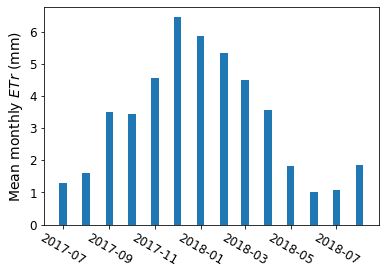

In [ ]:
def sample(geo):
    def inner(img):
        etr = img.reduceRegion('mean', geometry.geometry(), 1000).values().get(0)
        date = ee.Date(img.get('system:time_start'))
        return ee.Feature(None, {'date':date.format('YYYY_MM_dd'),'etr':etr})
    return inner

etr_coll = testing.map(sample(geometry)).getInfo()
fig, ax = plt.subplots()
ax.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') for n in etr_coll['features']],
         [n['properties']['etr'] for n in etr_coll['features']], width=10)
ax.set_ylabel('Mean monthly $ETr$ (mm)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelsize=12, rotation=330)
ax.xaxis_date()

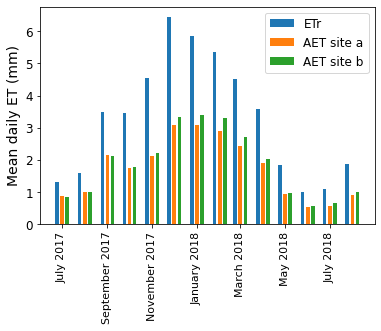

In [ ]:
# for article

from datetime import datetime, timedelta


def sample(x):
    def inner(img):
        etr = img.reduceRegion('mean', x.geometry(), 1000).values().get(0)
        date = ee.Date(img.get('system:time_start'))
        return ee.Feature(None, {'date':date.format('YYYY_MM_dd'),'etr':etr})
    return inner

etr_coll2 = testing.map(sample(geometry)).getInfo()
fig, ax = plt.subplots()
ax.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') - timedelta(days=7) for n in etr_coll['features']],
         [n['properties']['etr'] for n in etr_coll['features']], width=5, label='ETr')
ax.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') + timedelta(days=0) for n in eta_coll2['features']],
         [n['properties']['etr'] for n in eta_coll2['features']], width=5, label='AET site a')
ax.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') + timedelta(days=7) for n in eta_coll['features']],
         [n['properties']['etr'] for n in eta_coll['features']], width=5, label='AET site b')

ax.set_ylabel('Mean daily ET (mm)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
# tick_labels = ['July 2017', 'August 2017', 'September 2017', 'October 2017', 'November 2017',
#                'December 2017', 'January 2018', 'February 2018', 'March 2018', 'April 2018',
#                'May 2018', 'June 2018', 'July 2018', 'August 2018']
tick_labels = ['July 2017', 'September 2017', 'November 2017',
               'January 2018', 'March 2018',
               'May 2018',  'July 2018']
ax.set_xticklabels(tick_labels)
# ax.set_xticks([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') + timedelta(days=0) for n in eta_coll2['features']], tick_labels)
ax.tick_params(axis='x', labelsize=11, rotation=90)
ax.xaxis_date()
ax.legend(fontsize=10)
fig.savefig('drive/My Drive/ET_bar2(1).png', bbox_inches='tight', dpi=300)

In [ ]:
[pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') + timedelta(days=0) for n in eta_coll2['features']]

[Timestamp('2017-07-01 00:00:00'),
 Timestamp('2017-08-01 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-10-01 00:00:00'),
 Timestamp('2017-11-01 00:00:00'),
 Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00')]

### Calculating AET as ETr * Kc

In [ ]:
data = test.map(AET(monthly))

### Mapping AET for July using July average satellite image 

In [ ]:
mapidCon = test.first().getMapId({'min': 0, 'max': 0.3, 'bands': ['B8', 'B4', 'B3']})
mapidAET = ee.Image(data.first()).select('AET').getMapId({'min': 0, 'max': 6, 'palette': 'FF0000, FFFF00, 00FF00, 00FFFF, 0000FF'})
mapLot = ee.Feature(geometry).getMapId()
centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=13)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='sat',
  ).add_to(map)
folium.TileLayer(
    tiles=mapidAET['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='ETA',
  ).add_to(map)
folium.TileLayer(
    tiles=mapLot['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='paddock',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:
print(data.first().bandNames().getInfo())
ee.batch.Export.image.toDrive(data.select('AET').toBands().rename(band_names),
                              'AETLotB',
                              region=geometry.geometry(),
                              scale=10,
                              maxPixels=1e13).start()

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60', 'probability', 'NDVI', 'EVI', 'EVIr', 'GVMI', 'RMI', 'Kc', 'ETr', 'AET']


### Mean AET plot for the paddock

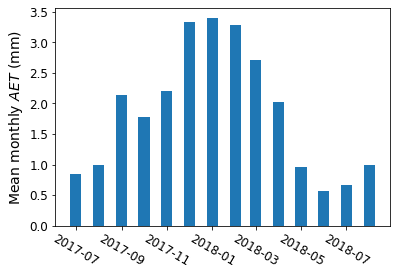

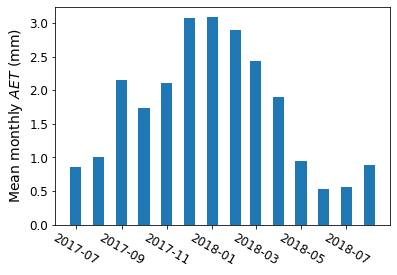

In [ ]:
eta_coll = data.select('AET').map(sample(geometry)).getInfo()
fig, ax = plt.subplots()
ax.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') for n in eta_coll['features']],
         [n['properties']['etr'] for n in eta_coll['features']], width=15)
ax.set_ylabel('Mean monthly $AET$ (mm)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelsize=12, rotation=330)
ax.xaxis_date()

eta_coll2 = data.select('AET').map(sample(geometry2)).getInfo()
fig, ax = plt.subplots()
ax.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') for n in eta_coll2['features']],
         [n['properties']['etr'] for n in eta_coll2['features']], width=15)
ax.set_ylabel('Mean monthly $AET$ (mm)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelsize=12, rotation=330)
ax.xaxis_date()
# fig.savefig('drive/My Drive/AET_205.png', bbox_inches='tight', dpi=300)

In [ ]:
mapidCon = geometry.getMapId()
mapidEVI = geometry2.getMapId()
# mapidKc = ee.Image(test.first()).select('Kc').getMapId({'min': 0, 'max': 0.8, 'palette': ['440154', '433982', '30678D', '218F8B', '36B677', '8ED542', 'FDE725']})
# mapDam = ee.Feature(ee.Feature(NSWdams.first()).geometry().buffer(200).bounds()).getMapId()
centroid = geo1.coordinates().getInfo()[::-1]
map = folium.Map(location=centroid, zoom_start=13)
folium.TileLayer(
    tiles=mapidCon['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='sat',
  ).add_to(map)
folium.TileLayer(
    tiles=mapidEVI['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='NDVI',
  ).add_to(map)

map.add_child(folium.LayerControl())
map

### Paddock estimations 

#### Water demand (AET)

In [ ]:
area = geometry.geometry().area(1).divide(10000).getInfo()
print('area =', area, 'ha')

area = 460.5465692073874 ha


In [ ]:
def demand_calc(geo, band, scale, monthly=None):
    def inner(img):
        # area = geometry.geometry().area(1)
        demand = ee.Image(img.select(band)).divide(1000).multiply(ee.Image.pixelArea()).reduceRegion('sum', geometry.geometry(), scale).values().get(0)
        date = ee.Date(img.get('system:time_start'))
        days = ee.Number(1)
        if monthly:
            days = date.advance(1, 'month').difference(date, 'day')
        return ee.Feature(None, {'date':date.format('YYYY_MM_dd'), 'demand':ee.Number(demand).multiply(days)})
    return inner


def offer_calc(geo, scale):
    def inner(img):
        area = geo.area(1)
        offer = ee.Image(img).divide(1000).reduceRegion('mean', geo.geometry(), scale).values().get(0)
        date = ee.Date(img.get('system:time_start'))
        # days = ee.Number(1)
        # if monthly:
        #     days = date.advance(1, 'month').difference(date, 'day')
        return ee.Feature(None, {'date':date.format('YYYY_MM_dd'), 'offer':ee.Number(offer).multiply(area)})
    return inner


### Monthly cummulated AET demand

In [ ]:
dem = data.map(demand_calc(geometry.geometry(), 'AET', 10, monthly))
demand_data = dem.getInfo()
# area = geometry.area().getInfo()

In [ ]:
# dem2 = data2.map(demand_calc(geometry.geometry(), 'AET', 10, monthly))
# demand_data2 = dem2.getInfo()
# area2 = geometry.area().getInfo()

In [ ]:
offer2 = gpm.map(offer_calc(geometry2, 10000))
offer_data2 = offer2.getInfo()

In [ ]:
area

460.5465692073874

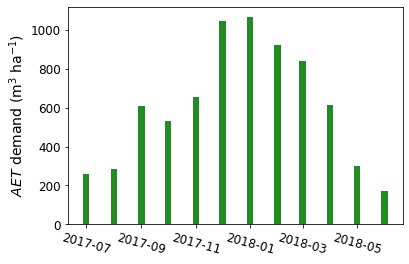

In [ ]:
fig, ax = plt.subplots()
ax.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') for n in demand_data['features']],
         [n['properties']['demand']/(area) for n in demand_data['features']], width=7, label='AET site b', color='forestgreen')
ax.set_ylabel('$AET$ demand (m$^3$ ha$^{-1}$)', fontsize=14)
ax.xaxis_date()
ax.tick_params(axis='both', labelsize=12)
ax.tick_params(axis='x', labelsize=12, rotation=345)
# ax.set_ylim(0, 3000)

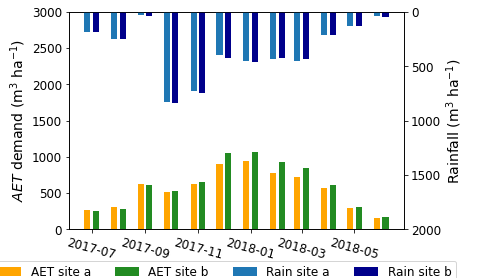

In [ ]:
# fig, ax = plt.subplots()
# ax.bar([pd.to_datetime(n['properties']['date'] , format='%Y_%m_%d') - timedelta(days=5) for n in demand_data['features']],
#          [n['properties']['demand']/(area2/10000) for n in demand_data['features']], width=7, label='AET site a', color='orange')
# ax.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') + timedelta(days=5)for n in demand_data2['features']],
#          [n['properties']['demand']/(area/10000) for n in demand_data2['features']], width=7, label='AET site b', color='forestgreen')
# ax.set_ylabel('$AET$ demand (m$^3$ ha$^{-1}$)', fontsize=14)
# ax.xaxis_date()
# ax.tick_params(axis='both', labelsize=12)
# ax.tick_params(axis='x', labelsize=12, rotation=345)
# ax.set_ylim(0, 3000)


# ax2 = ax.twinx()
# ax2.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') - timedelta(days=5) for n in offer_data2['features']],
#          [-n['properties']['offer']/(area2/10000) for n in offer_data2['features']], width=7, label='Rain site a')
# ax2.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') + timedelta(days=5)for n in offer_data['features']],
#          [-n['properties']['offer']/(area/10000) for n in offer_data['features']], width=7, label='Rain site b', color='darkblue')
# ax2.set_ylim(-2000, 0)
# y2_ticks = np.linspace(0, 2000, 5)
# y2_ticklabels = [str(int(i)) for i in y2_ticks]
# ax2.set_yticks(-1 * y2_ticks)
# ax2.set_yticklabels(y2_ticklabels)
# ax2.tick_params(axis='y', labelsize=12)
# ax2.set_ylabel('Rainfall (m$^3$ ha$^{-1}$)', fontsize=14)
# fig.legend(bbox_to_anchor=(1.07,0.08), fontsize=12, ncol=4)
# fig.savefig('drive/My Drive/demand_rain.png', bbox_inches='tight', dpi=300)

### Annual cummulated AET water demand per ha

In [ ]:
### cumulated annual AET for monthly basis
print('annual AET per ha =', np.sum([n['properties']['demand'] for n in demand_data['features']])/(area), 'm³')

annual AET per ha = 7294.353149174291 m³


### Rainfall

### Lumped rainfall in the paddock

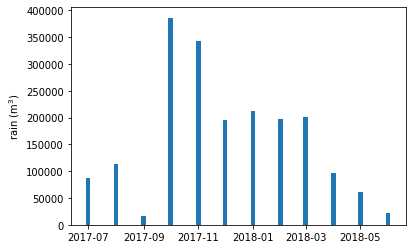

In [ ]:
def monthly_rain(img):
    date_start = ee.Date(img.get('system:time_start'))
    date_end = date_start.advance(1, 'month')
    days = date_end.difference(date_start, 'day')
    return img.multiply(ee.Image(days)).multiply(24).copyProperties(img, ['system:time_start', 'system:time_end'])


gpm = ee.ImageCollection("NASA/GPM_L3/IMERG_MONTHLY_V06").filterDate("2017-07-01", '2018-06-30').select('precipitation')

gpm = gpm.map(monthly_rain)
offer = gpm.map(offer_calc(geometry, 10000))
offer_data = offer.getInfo()
fig, ax = plt.subplots()
ax.bar([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') for n in offer_data['features']],
         [n['properties']['offer'] for n in offer_data['features']], width=5)
ax.set_ylabel('rain (m$^3$)')
ax.xaxis_date()

In [ ]:
print(gpm.size().getInfo())
ee.batch.Export.image.toDrive(gpm.select('precipitation').toBands().resample('bicubic').rename(band_names),
                              'RainLotA',
                              region=geometry2.geometry(),
                              scale=10,
                              maxPixels=1e13).start()

12


In [ ]:
print('annual rainfall =', np.sum([n['properties']['offer'] for n in offer_data['features']])/(area)/10, 'mm') #1mm = 10m³/ha

annual rainfall = 419.9152084439993 mm


In [ ]:
### for more continuous data (5 days Chirps)

# chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD").filterDate("2017-07-01", '2018-06-30')
# offer = chirps.map(demand_calc(geometry.geometry(), 'precipitation', 5000))
# offer = offer.getInfo()
# plt.plot([pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') for n in offer['features']],
#          [n['properties']['demand'] for n in offer['features']])
# plt.ylabel('rain (m$^3$)')

### Deficit (AET-pp)

Creation of dataframe with demand - rain - deficit

In [ ]:
months = [pd.to_datetime(n['properties']['date'], format='%Y_%m_%d') for n in offer_data['features']]
demands = [n['properties']['demand'] for n in demand_data['features']]
offers = [n['properties']['offer'] for n in offer_data['features']]
def_df = pd.DataFrame(index=months, data={'demand': demands, 'rain': offers})
def_df['defficit'] = def_df['demand'] - def_df['rain']
def_df

,demand,rain,defficit
2017-07-01,118606.118843,87247.975234,31358.143609
2017-08-01,131372.911161,113308.274138,18064.637023
2017-09-01,279096.381710,15779.665703,263316.716006
2017-10-01,244969.258862,386530.469669,-141561.210807
2017-11-01,301820.701988,342907.311132,-41086.609144
2017-12-01,481548.952058,196125.075679,285423.876379
2018-01-01,490452.384603,213022.127699,277430.256904
2018-02-01,424225.130435,197663.256436,226561.873999
2018-03-01,387676.768958,201605.766095,186071.002863
2018-04-01,282180.438156,97115.931650,185064.506506


### Water usage

Importing water usage data shared by Brian

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1YxBqgmWMI22AlpMyAh7SXKGgcCjg175n"})
downloaded.GetContentFile('wat_cluster_usage_ab_v3.xlsx')

In [ ]:
import pandas as pd
from scipy.interpolate import interp1d


water_usage = pd.read_excel('wat_cluster_usage_ab_v3.xlsx')

## Filtering dataset by paddock ID and plotting water Usage

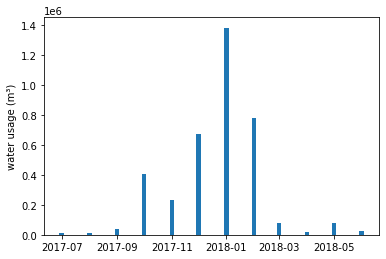

In [ ]:
water_usage = water_usage[water_usage['C_ID'] == geometry.get('C_ID').getInfo()]
water_usage['date'] = pd.to_datetime(water_usage['DATE_FROM'])
water_usage = water_usage.sort_values('date')
water_usage = water_usage.set_index('DATE_FROM')
water_usage = water_usage.resample('MS').sum()

fig, ax = plt.subplots()
ax.bar(water_usage.index, water_usage['TOTAL_USAGE']*1000, width=5)
ax.set_ylabel('water usage (m³)')
ax.xaxis_date()


In [ ]:
water_usage['TOTAL_USAGE']

DATE_FROM
2017-07-01      10.8245
2017-08-01       8.9987
2017-09-01      40.1259
2017-10-01     401.9864
2017-11-01     228.6917
2017-12-01     669.1927
2018-01-01    1379.8764
2018-02-01     778.1841
2018-03-01      76.5433
2018-04-01      19.5202
2018-05-01      80.6745
2018-06-01      23.9817
Freq: MS, Name: TOTAL_USAGE, dtype: float64

In [ ]:
def_df['water_use'] = water_usage['TOTAL_USAGE'] * 1000 # assumed ML 

In [ ]:
def_df['water_use']

2017-07-01      10824.5
2017-08-01       8998.7
2017-09-01      40125.9
2017-10-01     401986.4
2017-11-01     228691.7
2017-12-01     669192.7
2018-01-01    1379876.4
2018-02-01     778184.1
2018-03-01      76543.3
2018-04-01      19520.2
2018-05-01      80674.5
2018-06-01      23981.7
Name: water_use, dtype: float64

### Water per ha

In [ ]:
table = def_df/area
table = table.append(table.sum(numeric_only=True), ignore_index=True)
table.round(2)

,demand,rain,defficit,water_use
0,257.53,189.44,68.09,23.50
1,285.25,246.03,39.22,19.54
2,606.01,34.26,571.75,87.13
3,531.91,839.29,-307.38,872.85
4,655.35,744.57,-89.21,496.57
5,1045.60,425.85,619.75,1453.04
6,1064.94,462.54,602.39,2996.17
7,921.13,429.19,491.94,1689.70
8,841.78,437.75,404.02,166.20
9,612.71,210.87,401.84,42.38


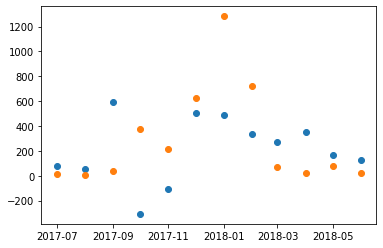

In [ ]:
plt.scatter(def_df.index, def_df['defficit']/area)
plt.scatter(def_df.index, def_df['water_use']/area)

### Annual water usage per ha

In [ ]:
print('annual water use =', def_df['water_use'].sum()/area, 'm³/ha')


annual water use = 3458.360698052735 m³/ha


### Annual cumulated AET per ha

In [ ]:
print('annual cumulated AET =', def_df['demand'].sum()/area, 'm³/ha')

annual cumulated AET = 6685.925758351525 m³/ha


### Lumped annual deficit per ha

In [ ]:
print('annual cumulated defficit =', def_df['defficit'].sum()/area, 'm³/ha')

annual cumulated defficit = 2546.7527506695587 m³/ha


In [ ]:
def_df.sum()

demand       6.873915e+06
rain         4.255555e+06
defficit     2.618360e+06
water_use    3.555600e+06
dtype: float64

### Dam calculations imported from files

In [ ]:

downloaded1 = drive.CreateFile({'id':"1R5qX1pB6Nss6GuLH4LUQXkla6fAjUNbx"})
downloaded1.GetContentFile('example1_1.pkl')


downloaded2 = drive.CreateFile({'id':"1lRHUs_jhjvEDgewDYMIZubMp48M076iZ"})
downloaded2.GetContentFile('example1_2.pkl')


downloaded3 = drive.CreateFile({'id':"1HZ9ihuKz9jx9F0dQkhNSrME9rXprmik3"})
downloaded3.GetContentFile('curve.csv')


In [ ]:
dat1 = pd.read_pickle('example1_1.pkl')
dat2 = pd.read_pickle('example1_2.pkl')

dat = dat1 + dat2

In [ ]:
[pd.to_datetime(n[0]) for n in dat]

[Timestamp('2017-07-02 00:00:00'),
 Timestamp('2017-07-07 00:00:00'),
 Timestamp('2017-07-09 00:00:00'),
 Timestamp('2017-07-22 00:00:00'),
 Timestamp('2017-07-27 00:00:00'),
 Timestamp('2017-07-29 00:00:00'),
 Timestamp('2017-08-16 00:00:00'),
 Timestamp('2017-08-18 00:00:00'),
 Timestamp('2017-08-23 00:00:00'),
 Timestamp('2017-08-31 00:00:00'),
 Timestamp('2017-09-05 00:00:00'),
 Timestamp('2017-09-20 00:00:00'),
 Timestamp('2017-09-27 00:00:00'),
 Timestamp('2017-10-10 00:00:00'),
 Timestamp('2017-10-17 00:00:00'),
 Timestamp('2017-10-27 00:00:00'),
 Timestamp('2017-10-30 00:00:00'),
 Timestamp('2017-11-04 00:00:00'),
 Timestamp('2017-11-09 00:00:00'),
 Timestamp('2017-11-11 00:00:00'),
 Timestamp('2017-12-01 00:00:00'),
 Timestamp('2017-12-06 00:00:00'),
 Timestamp('2017-12-09 00:00:00'),
 Timestamp('2017-12-14 00:00:00'),
 Timestamp('2017-12-16 00:00:00'),
 Timestamp('2017-12-19 00:00:00'),
 Timestamp('2018-01-05 00:00:00'),
 Timestamp('2018-01-08 00:00:00'),
 Timestamp('2018-01-

In [ ]:
# 2
downloaded1 = drive.CreateFile({'id':"1--CSx1a-3K_-zqgGSo2bXDnCTx9UXrnW"})
downloaded1.GetContentFile('example1_1.pkl')


downloaded2 = drive.CreateFile({'id':"1-0-nnsKTV8HFWIUSrt_XumLDpTkKZXQU"})
downloaded2.GetContentFile('example1_2.pkl')


downloaded3 = drive.CreateFile({'id':"1h_TnSFxe5eDFp9IZxnNmE8Z42Mc_qpyY"})
downloaded3.GetContentFile('curve.csv')


In [ ]:
curves = pd.read_csv('curve.csv')
levels = curves['level']
volumes = curves['volume']
interpolator = interp1d(levels, volumes, bounds_error=False, fill_value='extrapolate')

In [ ]:
levels

0     192.104993
1     192.154993
2     192.204993
3     192.254993
4     192.304993
5     192.354993
6     192.404993
7     192.454993
8     192.504993
9     192.554993
10    192.604993
11    192.654993
12    192.704993
13    192.754993
14    192.804993
15    192.854993
16    192.904993
17    192.954993
18    193.004993
19    193.054993
20    193.104993
21    193.154993
22    193.204993
23    193.254993
24    193.304993
25    193.354993
26    193.404993
27    193.454993
28    193.504993
29    193.554993
30    193.604993
31    193.654993
32    193.704993
33    193.754993
34    193.804993
35    193.854993
36    193.904993
37    193.954993
38    194.004993
39    194.054993
40    194.104993
41    194.108669
Name: level, dtype: float64

In [ ]:
np.array([n[-1][0]+0.2 if str(type(n[-1])) == "<class 'numpy.ndarray'>" else levels[0] for n in dat])

array([192.10499268, 192.10499268, 192.10499268, 192.10499268,
       192.62881762, 192.88486379, 192.87009786, 192.8307439 ,
       192.8151667 , 192.97764528, 193.0998319 , 193.15142491,
       193.43244388, 193.67975462, 194.18545657, 194.28210789,
       194.24568066, 192.60184671, 194.25808674, 194.29525377,
       194.26310818, 194.16728199, 194.25108856, 194.24992622,
       194.00754259, 194.08169793, 194.1093377 , 193.7534351 ,
       193.40786929, 193.65686778, 193.79776655, 194.16206525,
       193.82771649, 194.19845789, 193.65075803, 193.65925671,
       193.59344536, 193.54260048, 193.52640596, 193.47254388,
       193.45351693, 193.35915663, 193.32957165, 193.25957126,
       193.17142996, 193.15385522, 193.15157864, 193.14953455])

In [ ]:
dat1 = pd.read_pickle('example1_1.pkl')
dat2 = pd.read_pickle('example1_2.pkl')

dat = dat1 + dat2

dates = [pd.to_datetime(n[0]) for n in dat]
medians = np.array([interpolator(n[-1][1]) if str(type(n[-1])) == "<class 'numpy.ndarray'>" else levels[0] for n in dat]).ravel()
p16 = np.array([interpolator(n[-1][0]-0.2) if str(type(n[-1])) == "<class 'numpy.ndarray'>" else levels[0] for n in dat]).ravel()
p84 = np.array([interpolator(n[-1][0]+0.2) if str(type(n[-1])) == "<class 'numpy.ndarray'>" else levels[0] for n in dat]).ravel()
# medians = np.array([interpolator(n[-1][1]) for n in dat]).ravel()
# p16 = np.array([interpolator(n[-1][0]-0.2) for n in dat]).ravel()
# p84 = np.array([interpolator(n[-1][0]+0.2) for n in dat]).ravel()

In [ ]:
dat

[('2019-7-12', 0, 0),
 ('2019-7-17', 0, 0),
 ('2019-7-27', 0, 0),
 ('2019-8-1', 0, 0),
 ('2019-8-6',
  array([ 3.34122587e-02, -1.03563162e+01, -1.22378072e+00,  1.26247680e+00,
          4.77685263e+00, -2.84328659e+00,  2.79103993e+00,  1.51798394e+00,
          1.92706152e+02]),
  array([192.42881762, 192.60712903, 193.33914883])),
 ('2019-8-16', array([  0.21200827,  -9.91057277,   3.79765557,   2.12400728,
           3.86745303,   0.53799508,   0.97409364,   0.83482796,
         192.68708458]), array([192.68486379, 192.68700971, 193.12636303])),
 ('2019-8-21',
  array([ 1.64280829e-01, -9.00640155e+00,  3.49888668e+00,  2.71159325e+00,
          2.33692964e+00,  5.02425163e-01,  8.40971676e-01,  7.21811807e-01,
          1.92671060e+02]),
  array([192.67009786, 192.67149323, 192.97414278])),
 ('2019-8-26',
  array([ 1.70667031e-01, -8.52362596e+00,  6.58861488e-01,  2.44162897e+00,
          2.46221410e+00,  3.61945627e-01,  1.10905301e+00,  8.88034977e-01,
          1.92633046e+0

In [ ]:
str(type(dat[4][-1]))

"<class 'numpy.ndarray'>"

In [ ]:
[n[-1][1] if str(type(n[-1])) == "<class 'numpy.ndarray'>" else levels[0] for n in dat]

[192.1049926757813,
 192.1049926757813,
 192.1049926757813,
 192.1049926757813,
 192.60712902715096,
 192.6870097128841,
 192.67149322705478,
 192.63428266473235,
 192.61895567590943,
 192.7790429805691,
 192.90060993545617,
 192.95206856821997,
 193.26302373076982,
 193.5211704384498,
 194.04782881689715,
 194.10255794216343,
 194.08622665125628,
 192.82928967023432,
 194.09616945467417,
 194.10438085374818,
 194.09468219249908,
 194.01213430097278,
 194.09049192346566,
 194.0907849379253,
 193.90687055904687,
 193.91107073611613,
 193.93973740565542,
 193.58076256445227,
 193.25831940126585,
 193.4843688058116,
 193.6368260143817,
 194.02361037089446,
 193.6559622039412,
 194.05786876951316,
 193.47625798473257,
 193.48327759771723,
 193.41116777359906,
 193.36257737468745,
 193.3492304250345,
 193.2920041643997,
 193.26933039434348,
 193.17975601029121,
 193.15314467256712,
 193.0836792000592,
 192.98050093997148,
 192.95468330961515,
 192.95206114824347,
 192.95006170822333]

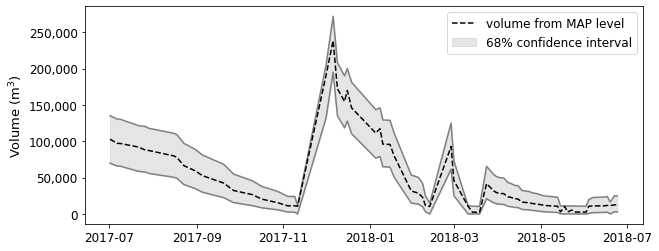

In [ ]:
fig = plt.figure(figsize=(10,4))

plt.plot(dates, p84, color='grey')
plt.plot(dates, p16, color='grey')
plt.plot(dates, medians, color='black', linestyle='--', label='volume from MAP level')
plt.fill_between(dates, p84, p16,
                 color='gray', alpha=0.2, label='68% confidence interval')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Volume (m$^3$)', fontsize=13)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
plt.savefig('drive/My Drive/reservoir_b.png', dpi=300)

In [ ]:
ee.batch.Export.image.toDrive(ee.Image(testing.first()).resample('bicubic'), 'etr', scale=10000, maxPixels=1e13).start()

In [ ]:
ee.batch.Export.image.toDrive(data.filterDate('2017-07-01', '2018-07-01').first().select(['B8', 'B4', 'B3', 'Kc', 'AET']).clip(geometry.geometry().bounds()),
                              'july13',
                              region=geometry.geometry(),
                              scale=10).start()
                              

In [ ]:
df_dam = pd.DataFrame(index=dates, data={'volume':medians})
df_dam['diff'] = df_dam.diff()
df_dam['diff'][df_dam['diff'] < 0] = 0
df_dam = df_dam.resample('M').sum()

,volume,diff
2017-07-31,5.642222e+05,0.000000
2017-08-31,2.833080e+05,0.000000
2017-09-30,1.273547e+05,0.000000
2017-10-31,7.697337e+04,0.000000
2017-11-30,3.280537e+04,0.000000
2017-12-31,1.072508e+06,242926.388603
2018-01-31,5.314877e+05,5892.178170
2018-02-28,1.658076e+05,82518.872427
2018-03-31,1.660903e+05,39656.883924
2018-04-30,2.034415e+05,23.038483


volume    3.365083e+06
diff      3.915744e+05
dtype: float64

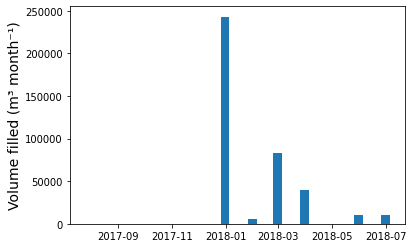

In [ ]:
fig, ax = plt.subplots()
ax.bar(df_dam.index, df_dam['diff'], width=10)
ax.xaxis_date()
ax.set_ylabel('Volume filled (m³ month⁻¹)', fontsize=14)
fig.show()

df_dam.sum()

In [ ]:
df_dam2 = pd.DataFrame(index=dates, data={'level_MAP':[n[1][-1] if type(n[1]) != int else levels[0] for n in dat],
                                          'level_p16':[n[-1][0] if type(n[-1]) != int else levels[0] for n in dat], 
                                          'level_p84':[n[-1][2] if type(n[-1]) != int else levels[0] for n in dat],
                                          'volume_MAP':[interpolator(n[1][-1]) if type(n[1]) != int else 0 for n in dat],
                                          'volume_p16':[interpolator(n[-1][0]) if type(n[-1]) != int else 0 for n in dat],
                                          'volume_p84':[interpolator(n[-1][2]) if type(n[-1]) != int else 0 for n in dat]
                                          })
# df_dam2
df_dam2.to_csv('drive/My Drive/dam1.csv')

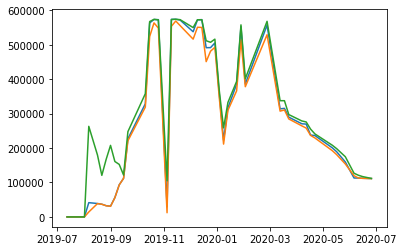

In [ ]:
plt.plot(df_dam2.index, df_dam2['volume_MAP'])
plt.plot(df_dam2.index, df_dam2['volume_p16'])
plt.plot(df_dam2.index, df_dam2['volume_p84'])